# Definition of the domain of interest and creation of the associated masks

This notebook aims to create the masks of the domain of interest of our study. 

First, we create the mask at T-point (Arakawa C-grid ; Mesinger and Arakawa, 1976) associated with our domain of interest. This domain has to be defined first. We finish by creating the masks at U- and V-points from the mask at T-point. 

Note that this notebook alone does not enable the creation of the mask at T-point. It needs to use an image editor. The process is explained below.

In [1]:
#Importation of the different libraries

##Loading of the NetCDF files
import xarray as xr

##Computing
import numpy as np

##Graphical display
import matplotlib.pyplot as plt

### The first step is to create the mask at T-point (tmask)

We want to create a mask corresponding to the domain of interest of our study, i.e., the domain of study of the predictability of the pack ice. Therefore, we choose a domain excluding the coastal areas and the Marginal Ice Zone (MIZ), where landfast ice and small ice floes, respectively, might behave differently than the central pack ice regarding predictability.

We use here an objective criterion to set up a given distance from the coast below which the fields are masked. The criterion makes use of a damping coefficient equal to 0 at the coasts and growing exponentially towards 1 offshore. (More explanations below)

For the MIZ, we manually masked areas too close to the sea ice edge. The aim is to not include the sea ice edge in the domain of interest during January-February-March 1997. Once the mask is done, we separately check this condition (not shown here).

**Preliminary mask with a chosen minimal distance to the coasts**

We first create a preliminary mask equal to 0 below a given distance to the coasts. For that we make use of the variable "a_i" of the file "damping_factor_lgrid15_sm3_pourLaurine.nc". It is a damping coefficient equal to 0 at the coasts and growing exponentially towards 1 offshore. To create the preliminary mask, we choose a threshold on a_i. Areas with a value of the damping coefficient below the threshold are masked. 

The file "damping_factor_lgrid15_sm3_pourLaurine.nc" is created with the Python script "generate_damping_factor.py" (Lu-generator package (Brankart 2024)) with lgrid=15 and sm=3.

In [2]:
#Loading the file containing the damping coefficient

dat_preli=xr.open_dataset("/lustre/fswork/projects/rech/cli/udf71br/lu-simulator/misc_tools/make_dist2coastmk/damping_factor_lgrid15_sm3_pourLaurine.nc")


In [3]:
#Saving the spatial dimensions of dat_preli

size_x0=dat_preli.a_i.sizes["x"]
size_y0=dat_preli.a_i.sizes["y"]
print("x",size_x0,"y",size_y0)

x 492 y 566


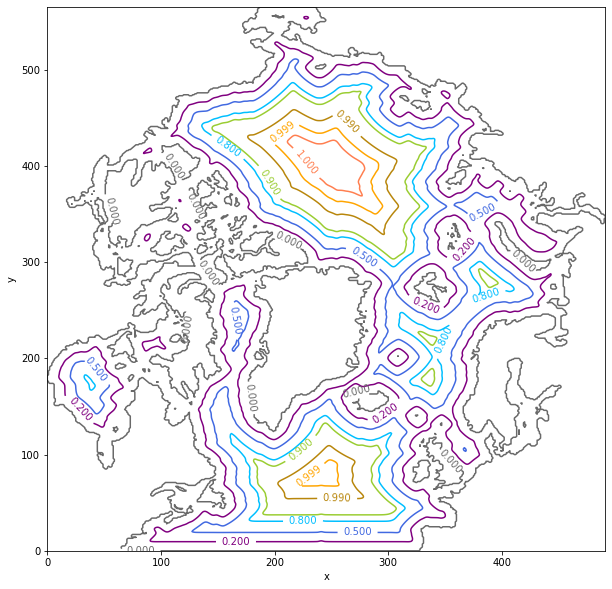

In [4]:
#Visualisation of the contours of some damping values

fig,ax=plt.subplots(figsize=(10,10))

c=plt.contour(dat_preli.a_i[0,0,:,:],levels=[0.0,0.2,0.5,0.8,0.9,0.99,0.999,0.9999],colors=["dimgray","purple","royalblue",\
                                                                                            "deepskyblue","yellowgreen","darkgoldenrod","orange","coral"])
ax.clabel(c, fontsize=10)
plt.xlabel("x") ; plt.ylabel("y")
plt.show()

In [5]:
#Choose the threshold used here

threshold=0.5 #value of the damping coefficient below which tmask is equal to 0

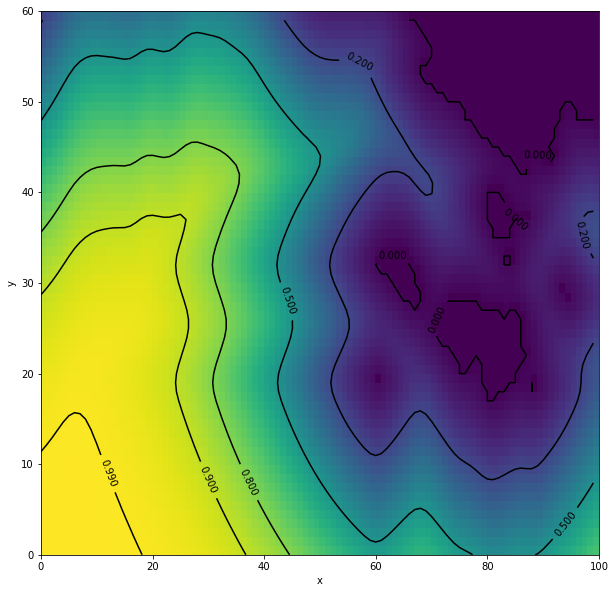

In [6]:
#Visualisation of the number of pixels between the coast and the contours corresponding to some values of the damping coefficient

fig,ax=plt.subplots(figsize=(10,10))

plt.pcolormesh(dat_preli.a_i[0,0,440:500,250:350])
c=plt.contour(dat_preli.a_i[0,0,440:500,250:350],levels=[0.0,0.2,0.5,0.8,0.9,0.99,0.999,0.9999],colors="black")
ax.clabel(c, fontsize=10)
plt.xlabel("x") ; plt.ylabel("y")
plt.show()

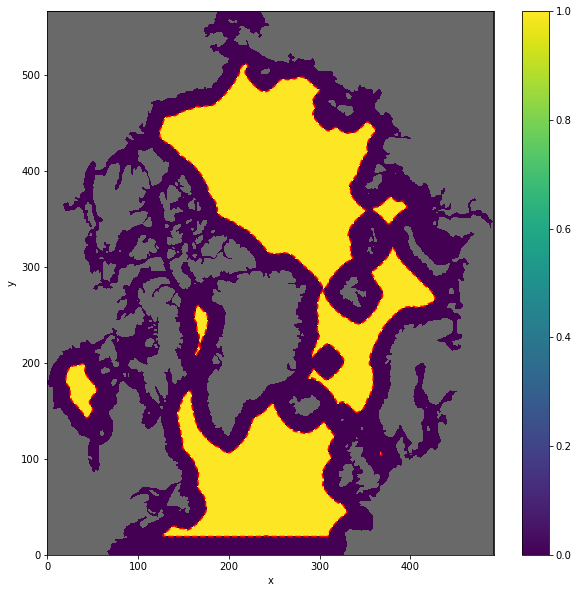

In [7]:
#Creation of the preliminary mask at T-point

mask_preli=xr.DataArray(data=np.ones((size_y0,size_x0)), dims=["y","x"])#initialisation

mask_preli=mask_preli.where(dat_preli.a_i[0,0,:,:]>threshold,0)#the mask is equal to 0 where dat_preli.a_i[0,0,:,:]<=threshold

##Visualisation of the result
fig,ax=plt.subplots(figsize=(10,10))
plt.pcolormesh(mask_preli) #our preliminary mask
plt.colorbar()
plt.contour(dat_preli.a_i[0,0,:,:],levels=[threshold],colors=["red"],linestyles="--")
plt.contourf(dat_preli.a_i.where(dat_preli.a_i==0)[0,0,:,:],colors="dimgrey") #localisation of the coast
plt.xlabel("x") ; plt.ylabel("y")
plt.show()

In [8]:
#Saving the preliminary mask into a NetCDF file

ds = xr.Dataset(
    {
    "tmask":    (["y","x"], np.int8(mask_preli)),
    }
)

# attributes for variable tmask:
ds.tmask.attrs['long_name'] = 'preliminary tmask'

# global attribute:
ds.attrs['history'] = 'preliminary tmask using damping_factor_lgrid15_sm3_pourLaurine.nc and a threshold of '+str(threshold)

# write the file with UNLIMITED time:
ds.to_netcdf("mask_preli_threshold"+str(threshold)+".nc")

**Excluding the MIZ from the final tmask**

To obtain the finalised tmask, and so to exclude the MIZ, we follow these steps:

- clone the GitHub repository: https://github.com/brodeau/climporn.git

- use it to convert the mask (e.g., tmask 1D) in a NetCDF format into an image:

climporn/python/scripts/NetCDF_to_imageBW.py \<netcdf_file.nc> \<netcdf_variable> \<image_extension (jpg,png,bmp,...)> 

/!\ Prioritise the use of the .tiff extension

- open the resulting image (black=0 and white=1) with an image editor like GIMP

- color in black all the areas you want to mask

  In our case, it corresponds to the area too close to the sea ice edge and the areas between the islands of Canada.

- save the new image

- convert the resulting B&W image into a NetCDF file:

climporn/python/scripts/imageBW_to_NetCDF.py \<image>

At the end of these steps, you have your final tmask!

### The second step is to create masks at U- and V- points (umask and vmask) from the mask at T-point (tmask)

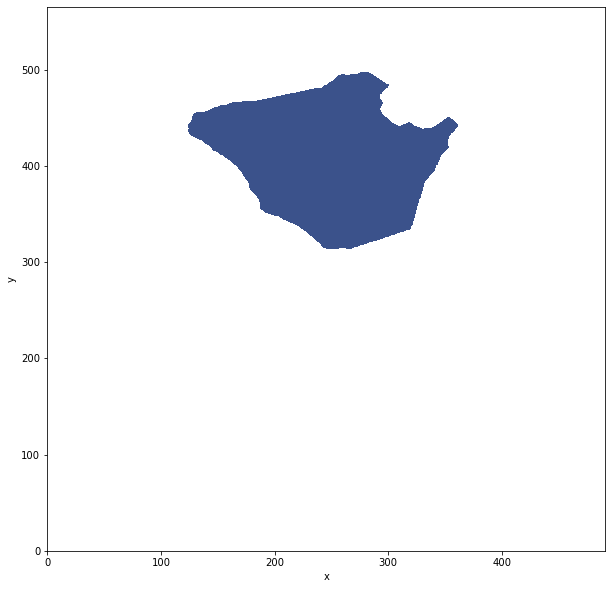

In [9]:
#Loading the tmask file created during the first phase

dat=xr.open_dataset("../Masks/mask_final_threshold"+str(threshold)+".nc")

dat=dat.rename({"bw":"tmask"}) #rename "tmask" the variable corresponding to the tmask

##Visualisation of the domain tmask

fig,ax=plt.subplots(figsize=(10,10))
plt.contourf(dat.tmask.where(dat.tmask>0))
plt.xlabel("x") ; plt.ylabel("y")
plt.show()

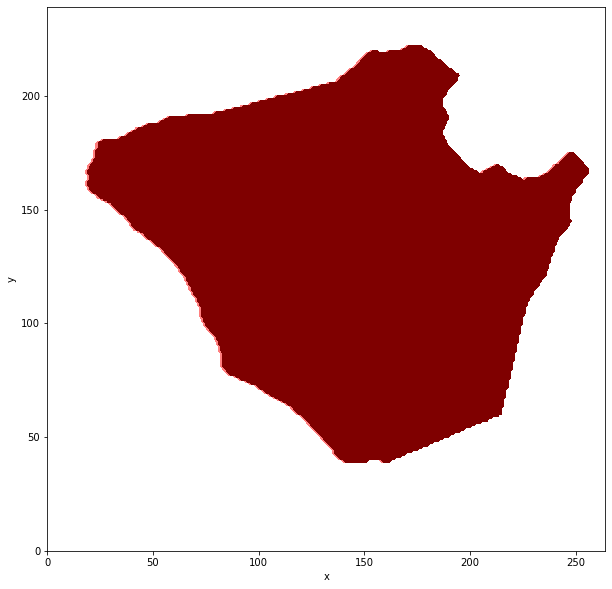

In [10]:
#Creation of umask

umask=xr.DataArray(data=np.zeros((size_y0,size_x0)), dims=["y","x"])

umask[:,:-1]=np.minimum(dat.tmask[:,1:]+dat.tmask[:,:-1],1)

##Visualisation of the result

fig,ax=plt.subplots(figsize=(10,10))
plt.contourf(dat.tmask.where(dat.tmask>0)[275:515,105:370],colors="black")
plt.contourf(umask.where(umask>0)[275:515,105:370],alpha=0.5,colors="red")
plt.xlabel("x") ; plt.ylabel("y")
plt.show()

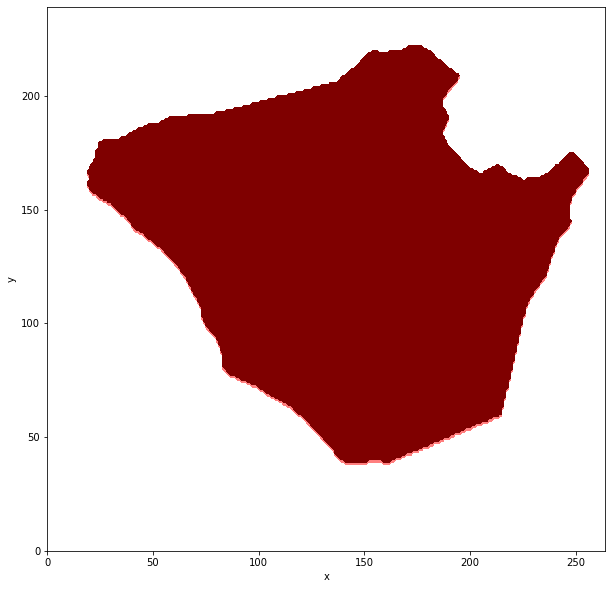

In [11]:
#Creation of vmask

vmask=xr.DataArray(data=np.zeros((size_y0,size_x0)), dims=["y","x"])

vmask[:-1,:]=np.minimum(dat.tmask[1:,:]+dat.tmask[:-1,:],1)

##Visualisation of the result

fig,ax=plt.subplots(figsize=(10,10))
plt.contourf(dat.tmask.where(dat.tmask>0)[275:515,105:370],colors="black")
plt.contourf(vmask.where(vmask>0)[275:515,105:370],alpha=0.5,colors="red")
plt.xlabel("x") ; plt.ylabel("y")
plt.show()

In [12]:
#Saving all masks into the same NetCDF file

##Define variables:
ds = xr.Dataset(
    {
    "tmask":    (["y","x"], dat.tmask.data),
    "umask":       (["y","x"], np.int8(umask)),
    "vmask":    (["y","x"], np.int8(vmask))
    }
)

##Attributes for variable tmask:
ds.tmask.attrs['long_name'] = 'mask at T-point'

##Attributes for variable umask:
ds.umask.attrs['long_name'] = 'mask at U-point'

##Attributes for variable vmask:
ds.vmask.attrs['long_name'] = 'mask at V-point'

##Global attribute:
ds.attrs['history'] = 'created using the script "11-12-2024_TUVmasks.ipynb"'

##Write the file:
ds.to_netcdf("masks_domain_threshold_"+str(threshold)+"test.nc")